In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
import scipy
import matplotlib.dates as mdates
from datetime import datetime
sys.path.append('..')
from read_data_functions import *
from plot_functions import *
from calculations import *

In [2]:
parent_path = '../../../../'
path = 'L:/PG-Nanoteknologi/PROJEKTER/2024 Laura og Nan/Lund/'

SMPS = read_SMPS(path, parent_path, [0, 0])
OPS_APS = read_OPS(path, parent_path)

Failed to read file with separation: 	
Failed to read file with separation: ,
Failed to read file with separation: ,
Failed to read file with separation: 	
Failed to read file with separation: ,
Failed to read file with separation: ,


In [3]:
timestamps_exp = [['2024-10-16 10:45:00', '2024-10-16 12:26:00'],
                  ['2024-10-16 15:00:00', '2024-10-16 15:34:00'],
                  ['2024-10-17 10:20:00', '2024-10-17 12:00:00'],
                  ['2024-10-17 14:30:00', '2024-10-17 15:00:00']]

ax_labels = ['Particle diameter / $\mu$m', 'Number concentration / #/cm$^{3}$', 'Mass concentration / $\mu$g/m$^{3}$']

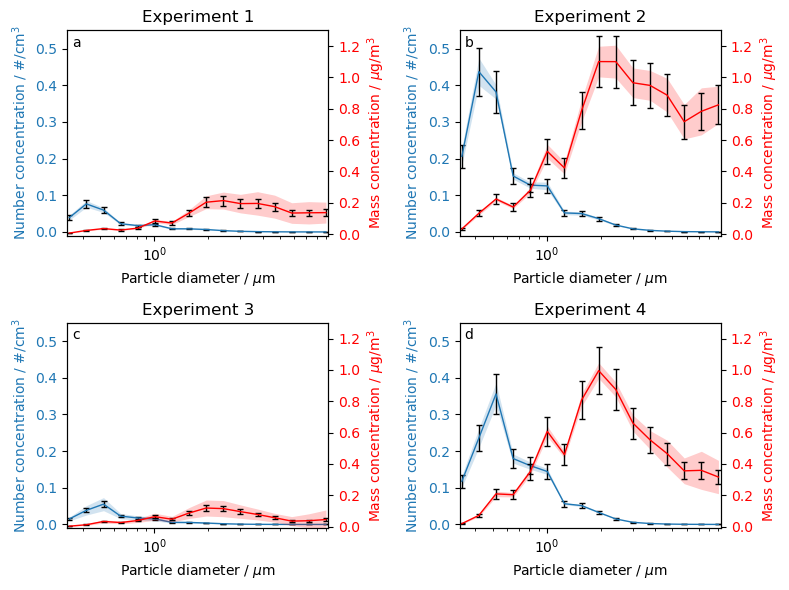

In [4]:
OPS_dict_keys = ['Exp1', 'Exp2', 'Exp3', 'Exp4']
OPS_mid_point = [0.337, 0.419, 0.522, 0.650, 0.809, 1.007, 1.254, 1.562, 1.944, 2.421, 3.014, 3.752, 4.672, 5.816, 7.241, 9.015]
OPS_cut_point = [0.300, 0.374, 0.465, 0.579, 0.721, 0.897, 1.117, 1.391, 1.732, 2.156, 2.685, 3.343, 4.162, 5.182, 6.451, 8.031, 10.000]
OPS_bins = OPS_APS['Exp1'].keys()[1:17].to_list()

OPS_mass_conc = {}
for key in OPS_dict_keys:
    mass_conc = calc_mass_conc(OPS_APS[key], OPS_bins, OPS_mid_point, 7.86)
    OPS_mass_conc[key] = mass_conc

fig, axes = plt.subplots(2, 2, figsize = (8, 6))

for i, key in enumerate(OPS_dict_keys):
    if i == 0:
        ax = axes[0][0]
    if i == 1:
        ax = axes[0][1]
    if i == 2:
        ax = axes[1][0]
    if i == 3:
        ax = axes[1][1]

    number, mass, ax, ax2 = plot_bin_mean(ax, timestamps_exp[i], OPS_APS[key], OPS_mass_conc[key], OPS_bins, 'Time', OPS_mid_point, ['tab:blue', 'red'], 0.15, ax_labels, mass = True)

    ax.set_xlim(min(OPS_mid_point) - 0.01, max(OPS_mid_point) + 0.3)
    ax.set_ylim(-0.01, 0.55)
    ax2.set_ylim(-0.01, 1.3)
    
    title = 'Experiment ' + str(i + 1)
    ax.set_title(title)

sublabels = ['a', 'b', 'c', 'd']
for ax, l in zip(axes.flatten(), sublabels):
    ax.text(0.02, 0.92, l, transform = ax.transAxes, fontsize = 10)

fig.tight_layout()
fig.savefig('Mean_concentrations/OPS_mean.png', dpi = 600)

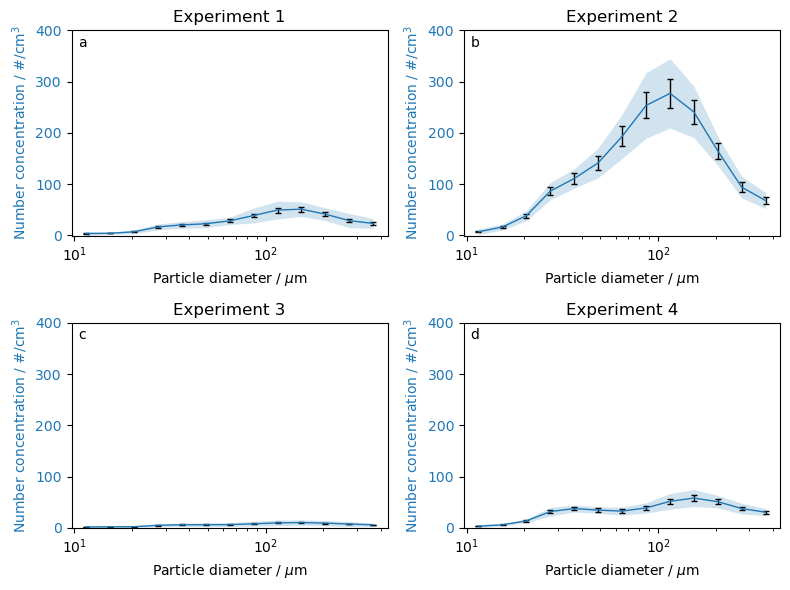

In [5]:
NanoScan_dict_keys = ['2024-10-16_NanoScan', '2024-10-16_NanoScan', '2024-10-17_NanoScan', '2024-10-17_NanoScan']
NanoScan_bin_mean = []
for key in SMPS['2024-10-16_NanoScan'].keys()[3:16]:
    NanoScan_bin_mean.append(float(key))
NanoScan_Bins = SMPS['2024-10-16_NanoScan'].keys()[3:16].to_list()

fig, axes = plt.subplots(2, 2, figsize = (8, 6))

for i, key in enumerate(NanoScan_dict_keys):
    if i == 0:
        ax = axes[0][0]
    if i == 1:
        ax = axes[0][1]
    if i == 2:
        ax = axes[1][0]
    if i == 3:
        ax = axes[1][1]

    number, mass, ax, ax2 = plot_bin_mean(ax, timestamps_exp[i], SMPS[key], None, NanoScan_Bins, 'Time', NanoScan_bin_mean, ['tab:blue'], 0.10, ax_labels, mass = False)

    ax.set_ylim(-0.5, 400)

    title = 'Experiment ' + str(i + 1)
    ax.set_title(title)

sublabels = ['a', 'b', 'c', 'd']
for ax, l in zip(axes.flatten(), sublabels):
    ax.text(0.02, 0.92, l, transform = ax.transAxes, fontsize = 10)

fig.tight_layout()
fig.savefig('Mean_concentrations/NanoScan_mean.png', dpi = 600)

In [6]:
APS_dict_keys = ['20241016_APS', '20241016_APS_2_exp', '20241017_APS', '20241017_APS']
APS_bins = OPS_APS['20241016_APS'].keys()[5:56].to_list()
APS_bin_mean = []
for key in OPS_APS['20241016_APS'].keys()[5:56]:
    APS_bin_mean.append(float(key))
    OPS_APS['20241016_APS'][key] = pd.to_numeric(OPS_APS['20241016_APS'][key], errors='coerce') * 7.86

APS_mass_conc = {}
APS_mass_conc['20241016_APS'] = OPS_APS['20241016_APS']
for key in APS_dict_keys[1:]:
    mass_conc = calc_mass_conc(OPS_APS[key], APS_bins, APS_bin_mean, 7.86)
    APS_mass_conc[key] = mass_conc

APS_number = pd.DataFrame({'Time': OPS_APS['20241016_APS']['Time']})
for i, key in enumerate(APS_bins):
        # Ensure df[key] is numeric
        OPS_APS['20241016_APS'][key] = pd.to_numeric(OPS_APS['20241016_APS'][key], errors='coerce')
        
        APS_number[key] = OPS_APS['20241016_APS'][key] / ((7.86 / 10**6) * (np.pi / 6) * APS_bin_mean[i]**3 * 10**6) # in #/cm**3
OPS_APS['20241016_APS'] = APS_number

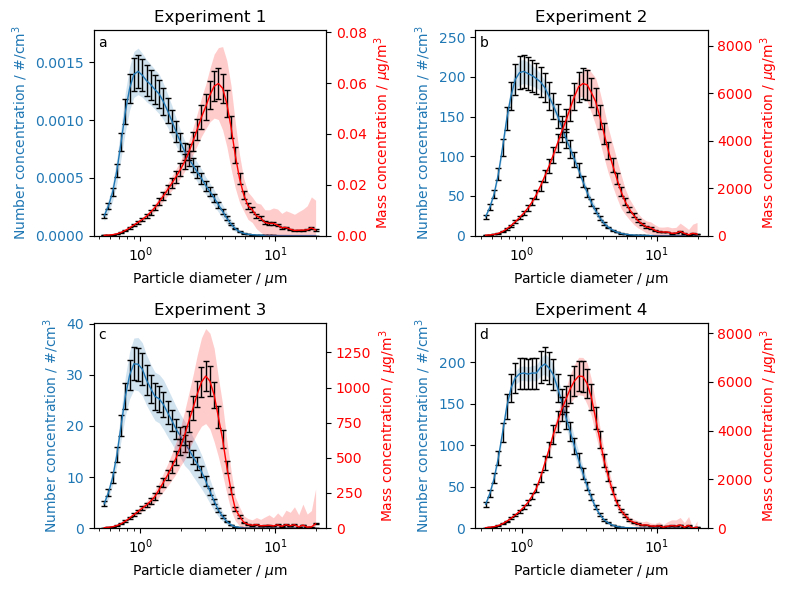

In [15]:
fig, axes = plt.subplots(2, 2, figsize = (8, 6))

for i, key in enumerate(APS_dict_keys):
    if i == 0:
        ax = axes[0][0]
    if i == 1:
        ax = axes[0][1]
    if i == 2:
        ax = axes[1][0]
    if i == 3:
        ax = axes[1][1]

    number, mass, ax, ax2 = plot_bin_mean(ax, timestamps_exp[i], OPS_APS[key], APS_mass_conc[key], APS_bins, 'Time', APS_bin_mean, ['tab:blue', 'red'], 0.10, ax_labels, mass = True)
    
    ax.set_ylim(0, max(number) + 0.25 * max(number))
    ax2.set_ylim(0, max(mass) + 0.35 * max(mass))

    title = 'Experiment ' + str(i + 1)
    ax.set_title(title)

sublabels = ['a', 'b', 'c', 'd']
for ax, l in zip(axes.flatten(), sublabels):
    ax.text(0.02, 0.92, l, transform = ax.transAxes, fontsize = 10)

fig.tight_layout()
fig.savefig('Mean_concentrations/APS_mean.png', dpi = 600)

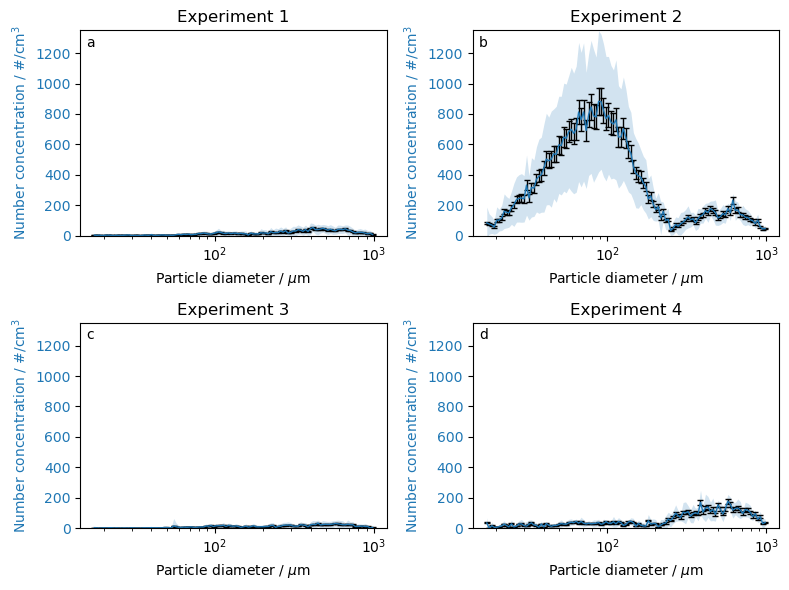

In [17]:
SMPS_dict_keys = ['20241016_SMPS', '20241016_SMPS_2_exp', '20241017_SMPS', '20241017_SMPS']
SMPS_bins = SMPS['20241016_SMPS'].keys()[83:196].to_list()
SMPS_bin_mean = []
for key in SMPS['20241016_SMPS'].keys()[83:196]:
    SMPS_bin_mean.append(float(key))

fig, axes = plt.subplots(2, 2, figsize = (8, 6))

for i, key in enumerate(SMPS_dict_keys):
    if i == 0:
        ax = axes[0][0]
    if i == 1:
        ax = axes[0][1]
    if i == 2:
        ax = axes[1][0]
    if i == 3:
        ax = axes[1][1]

    number, mass, ax, ax2 = plot_bin_mean(ax, timestamps_exp[i], SMPS[key], None, SMPS_bins, 'Time', SMPS_bin_mean, ['tab:blue'], 0.10, ax_labels, mass = False)

    ax.set_ylim(-0.1, 1350)

    title = 'Experiment ' + str(i + 1)
    ax.set_title(title)
    
sublabels = ['a', 'b', 'c', 'd']
for ax, l in zip(axes.flatten(), sublabels):
    ax.text(0.02, 0.92, l, transform = ax.transAxes, fontsize = 10)

fig.tight_layout()
fig.savefig('Mean_concentrations/SMPS_mean.png', dpi = 600)